<a href="https://colab.research.google.com/github/rhodes-byu/RF-Proximities-Workshop/blob/main/demo.ipynb" target="_blank">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Random Forest Proximities and Their Applications in Data Science

## Intro

In this demo, we will cover the basics of random forests (RF), focusing primarily on random forest proximities. Proximities form a supervised similarity measure that serve as the basis for a variety of applications. Specifically, we will be covering the use of RF proximities for imputation, visualization for data exploration, outlier detecion, and uncertainty quantification.

### Installation and Imports
Although viewed by Leo Breiman (random forest's primary author) as one of the most important aspects of random forests, Scikit-Learn's implementation of random forests does not implement them!  We will thus be relying on the RF-GAP-Python package to generate proximities for our applications. The installation is done by running the below cell:

In [ ]:
!pip install git+https://github.com/jakerhodes/RF-GAP-Python

In [ ]:
from rfgap import RFGAP, impute
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.manifold import MDS
from sklearn.tree import plot_tree

#### Loading the Data
First we will read in the `Titanic` dataset using `fetch_openml`. The dataset contains information about passengers on the Titanic, including items such as their name, sex, class, and whether they survived or not.

In [ ]:
# Read in Titanic
titanic = fetch_openml('titanic', version=1, as_frame=True)

In [ ]:
titanic.keys()

In [ ]:
titanic.data.head()

In [ ]:
titanic.data.info()

In [ ]:
X = titanic.data.copy()
X.drop(['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest'], axis=1, inplace=True)

# One-hot encoding of categorical variables
X_one_hot = pd.get_dummies(X, drop_first=False)
y = titanic.target.to_numpy(dtype = int)

In [ ]:
X.info()

Note that age, fare, and embarked have missing values. We can impute them using the RF-GAP proximities.

### Missing Value Imputation

Leo Breiman described two methods for random forest imputation. The first method does not actually use the random forest at all, but simply imputes using the mean, median, or most frequent category for an initial guess. The second method uses the random forest proximities to refine the imputation. Here is the original description:

---

**Random forests has two ways of replacing missing values.**

1. **Fast Method (Initial Guess)**

   - If the *m*th variable is **not categorical**, compute the **median** of all values of this variable in class *j*, then use this value to replace all missing values of the *m*th variable in class *j*.
   - If the *m*th variable is **categorical**, the replacement is the **most frequent non-missing** value in class *j*.
   - These replacement values are called **fills**.

2. **Proximity-Based Method (Refined Imputation)**

   - This method is **computationally more expensive** but has given better performance, even with large amounts of missing data.
   - It replaces missing values **only in the training set**.

   **Steps:**
   1. Perform a rough and inaccurate filling in of the missing values.
   2. Run a random forest and compute **proximities**.
   3. For a missing value:
      - If `x(m,n)` is a **missing continuous** value, estimate its fill as the **average** over the non-missing values of the *m*th variable, **weighted by the proximities** between the *n*th case and the cases with non-missing values.
      - If it is a **missing categorical** variable, replace it with the **most frequent non-missing** value, where **frequency is weighted by proximity**.
   4. **Iterate**:
      - Construct a new forest using the newly filled-in values.
      - Find new fills.
      - Repeat the process.

   - **Our experience is that 4–6 iterations are enough.**


In [ ]:
# Split up the data into a training and validation set
X_train, X_test, y_train, y_test = train_test_split(X_one_hot, y, test_size=0.2, random_state=42)

In [ ]:
# Impute the missing values using RF-GAP
X_train_imputed, X_test_imputed = impute.rfgap_impute(x = X_train, y = y_train, initialization = 'knn', x_test = X_test, random_state = 42)

In [ ]:
# Which values are acually missing?
X_missing = X_train.isna().sum(axis = 1)

In [ ]:
# Get a sense of the imputated value distribution
X_train_imputed_plot = X_train_imputed.copy()
X_train_imputed_plot['Sex'] = X_train_imputed_plot['sex_female'].map({1: 'female', 0: 'male'})
sns.swarmplot(data=X_train_imputed_plot, x='age', y='Sex', hue = X_missing)

In [ ]:
sns.kdeplot(data=X_train_imputed_plot, x='age', hue = X_missing)
plt.title('Distribution of Age by Missingness')

## Training the RandomForest

The RF-GAP class is a wrapper around the `RandomForestClassifier` or `RandomForestRegressor` from `sklearn`. It takes most of the same parameters, but has the added benefit of the proximity construction and subsequent applications. As with other models in `sklearn`, we train using the `model.fit(x, y)` method, and make predictions using the `model.predict(x)` method. Aftwerward, we can evalute the random forest model using our metric of choice.

To include the computation of the out-of-bag accuracy, we need to include the `oob_score = True` argument. We can access the score using `model.oob_score_`.

In [ ]:
# Here we define the random forest model using 500 trees. oob_score = True will provide an out-of-bag score.
rf = RFGAP(prox_method = 'rfgap', n_estimators = 500, oob_score = True, random_state = 42)
# Hint: RFGAP defaults to classification, include `y` as an argument or specifiy `prediction_type = 'regression'` for regression.

rf.fit(X_train_imputed, y_train)
print('OOB Score: ', rf.oob_score_)

### Individual trees

In [ ]:
# Get the first tree
tree = rf.estimators_[0]
# Plot the first tree

plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X_train_imputed.columns, class_names=['0', '1'], fontsize=10);

### How the information is stored in the RF model

In [ ]:
# Terminal node indices
terminal_nodes = rf.apply(X_train_imputed)

print(terminal_nodes.shape)
print(terminal_nodes[:5])

In [ ]:
# The paths of each observation through the forest
paths = rf.decision_path(X_train_imputed)[0].toarray()
print(paths.shape)
print(paths)

In [ ]:
# Counting the number of total nodes
np.max(terminal_nodes, axis = 0).sum()

In [ ]:
# Which indices pertain to which tree?
indicator, n_nodes_ptr = rf.decision_path(X_train_imputed)
print(n_nodes_ptr)

In [ ]:
# Getting the paths for a specific observation
sample_index = 0  # Which observation?
tree_paths = []
for i in range(rf.n_estimators):
    tree_paths.append(indicator[sample_index, n_nodes_ptr[i]:n_nodes_ptr[i+1]])

print(tree_paths[37].toarray()) # Which tree?

In [ ]:
indicator.toarray()

### Predictions on the Test Set
As with other `sklearn` models, we can use the `predict` method to make predictions on the test set. The `predict_proba` method will return the predicted probabilities for each class.

In [ ]:
yhat = rf.predict(X_test_imputed)
print(yhat)


In [ ]:
print('Test Score: ', rf.score(X_test_imputed, y_test))

Note the similarity between the test accuracy and OOB accuracy.

## Generating the proximities
The `RFGAP` class uses the built-in method `get_proximities` to generate the random forest proximities. By default, the RF-GAP proximities are generated across the full test set. Other options include the original and OOB versions of the proximities. 

As the RF-GAP proximities serves as weights (recall: $\hat{y_i}^{RF} = \sum_{j = 1}^{n}y_{j}p(i, j)$), each row of the proximity matrix sums to 1. 

In [ ]:
prox_rfgap = rf.get_proximities()
prox_rfgap.sum(axis = 1)

Proximity-based predicted probabilities

In [ ]:
y_train_hot = pd.get_dummies(y_train, drop_first=False)
weighted_sum = prox_rfgap @ y_train_hot
print(weighted_sum)

In [ ]:
# Comparing with the out-of-bag predictions
prox_predictions = np.argmax(weighted_sum, axis = 1)
oob_predictions = np.argmax(rf.oob_decision_function_, axis = 1)

In [ ]:
np.sum(oob_predictions == prox_predictions)

All of the proximity predictions match the OOB predictions!

### Visualization of the proximities

In [ ]:
# We symmetrize and scale the proximities for visualization
rf.force_symmetric = True
rf.non_zero_diagonal = True

In [ ]:
rfgap_symmetric = rf.get_proximities().toarray()

# Conversion of the proximities to distances
rf_distances = 1 - rfgap_symmetric

**Multidimensional scaling (MDS)** is used to find a lower-dimensional representation of high-dimensional data while preserving the distances between points as much as possible.

In [ ]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_emb = mds.fit_transform(rf_distances)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(22, 10))
markers = ['X', '.']
s = 80
sns.scatterplot(x=mds_emb[:, 0], y=mds_emb[:, 1], 
                hue=X_train_imputed.sex_male, style=y_train,
                palette='Set1', ax=axes[0], s=s,
                markers=markers)
axes[0].set_title("MDS by Sex")

sns.scatterplot(x=mds_emb[:, 0], y=mds_emb[:, 1], 
                hue=X_train_imputed.pclass, style=y_train, 
                palette='Dark2', ax=axes[1], s=s,
                markers=markers)
axes[1].set_title("MDS by Pclass")


for ax in axes:
    ax.legend(loc='upper left')
fig.suptitle("Proximity Visualization via MDS", fontsize=16)

We can do better!  Manifold learning is a set of tools for visualizing high dimensional data. Here, we apply UMAP to the proximities for a better low-dimensional representation or embedding.

In [ ]:
# !pip install umap-learn

In [ ]:
from umap import UMAP
umap = UMAP(metric = 'precomputed', random_state = 42)
umap_emb = umap.fit_transform(rf_distances)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(22, 10))
markers = ['X', '.']
s = 100
sns.scatterplot(x=umap_emb[:, 0], y=umap_emb[:, 1], 
                hue=X_train_imputed.sex_male, style=y_train,
                palette='Set1', ax=axes[0], s=s,
                markers=markers, alpha = 0.7)
axes[0].set_title("UMAP by Sex")

sns.scatterplot(x=umap_emb[:, 0], y=umap_emb[:, 1], 
                hue=X_train_imputed.pclass, style=y_train, 
                palette='Dark2', ax=axes[1], s=s,
                markers=markers)
axes[1].set_title("UMAP by Pclass")


for ax in axes:
    ax.legend(loc='upper left')
fig.suptitle("Proximity Visualization via UMAP", fontsize=16)

For a contrast, we view the UMAP embedding using the original data (unsupervised).

In [ ]:
umap_op = UMAP(metric = 'euclidean', random_state = 42)
umap_emb_euclidean = umap_op.fit_transform(X_train_imputed)
fig, axes = plt.subplots(1, 2, figsize=(22, 10))


sns.scatterplot(x=umap_emb_euclidean[:, 0], y=umap_emb_euclidean[:, 1], 
                hue=X_train_imputed.sex_male, style=y_train,
                palette='Set1', ax=axes[0], s=s,
                markers=markers, alpha = 0.7)
axes[0].set_title("UMAP by Sex")

sns.scatterplot(x=umap_emb_euclidean[:, 0], y=umap_emb_euclidean[:, 1], 
                hue=X_train_imputed.pclass, style=y_train, 
                palette='Dark2', ax=axes[1], s=s,
                markers=markers)
axes[0].set_title("UMAP by Pclass")

for ax in axes:
    ax.legend(loc='upper left')
fig.suptitle("Titanic via UMAP", fontsize=16)

            

## Assessing Outliers

Outliers are generally defined as cases that are removed from the main body of the data. Translate this as: outliers are cases whose proximities to all other cases in the data are generally small. A useful revision is to define outliers relative to their class. Thus, an outlier in class *j* is a case whose proximities to all other class *j* cases are small.

Define the average proximity from case *n* in class *j* to the rest of the training data class *j* as:

$$
\bar{P}(n) = \sum_{\text{cl}(k)=j} \text{prox}^2(n, k)
$$

The raw outlier measure for case *n* is defined as:

$$
\text{nsample} / \bar{P}(n)
$$

This will be large if the average proximity is small. Within each class, find the median of these raw measures, and their absolute deviation from the median. Subtract the median from each raw measure, and divide by the absolute deviation to arrive at the final


In [ ]:
outlier_scores = rf.get_outlier_scores(y_train)

In [ ]:
sns.scatterplot(x=umap_emb[:, 0], y=umap_emb[:, 1],
                size=np.log(outlier_scores + 1),
                sizes=(1, 100),
                markers=markers,
                hue=y_train,
                alpha=1)
plt.title("Sizing by RF Outier Scores")


### We can make the plot more interactive using the Plotly library. Plotly is not unique to Python, but is also available for R.

In [ ]:
# !pip install plotly
# !pip install nbformat # Not needed in Colab

import plotly.express as px

In [ ]:
# Set the desired visual size range
min_size = 1
max_size = 20

# Scale the outlier scores to the range [min_size, max_size]
scaled_sizes = np.interp(outlier_scores, 
                         (outlier_scores.min(), outlier_scores.max()), 
                         (min_size, max_size))


hover_df = pd.DataFrame(X_train_imputed).copy()
hover_df['outlier_score'] = outlier_scores
hover_df['sizes'] = scaled_sizes
hover_df['UMAP 1'] = umap_emb[:, 0]
hover_df['UMAP 2'] = umap_emb[:, 1]


# Plot with scaled sizes
fig = px.scatter(
    data_frame=hover_df,
    x='UMAP 1',
    y='UMAP 2',
    color=y_train.astype(str),
    size='sizes',
    size_max=max_size,
    labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'color': 'Survived'},
    title="Sizing by RF Outlier Scores",
    hover_data=hover_df[['age', 'sex_male', 'pclass', 'fare', 'outlier_score']],
    width=800,
    height=600,
)
fig.show()


## Uncertainty Quantification with RF-GAP (Classification)
We can use the RF-GAP proximities alongside the out-of-bag predictions to quantify uncertainty in our predictions. The idea is that if a sample is close to other samples of the same class, we can be more confident in our prediction. 

We start by constructing an out-of-bag misclassification vector and computing RF-GAP proximities. That is, given the vector

$$\mathbf{e} = [I(y_1 = \hat{y}^{\tilde{(B)}}_1), I(y_2 = \hat{y}^{\tilde{(B)}}_2), \cdots, I(y_n = \hat{y}^{\tilde{(B)}}_n)]^T $$
where $I$ is the $0-1$ indicator function, $\hat{y}_i^{\tilde{(B)}}$ is the out-of-bag prediction for $x_i$, we define the RF-ICE trust scores as a proximity-weighted sum of out-of-bag misclassifications, or 

$$
\mathcal{T} = \sum_{j = 1}^{n} w_{ij} I\left(y_j = \hat{y}^{\tilde{(B)}}_j\right) = \mathbf{W} \cdot \textbf{e}
$$


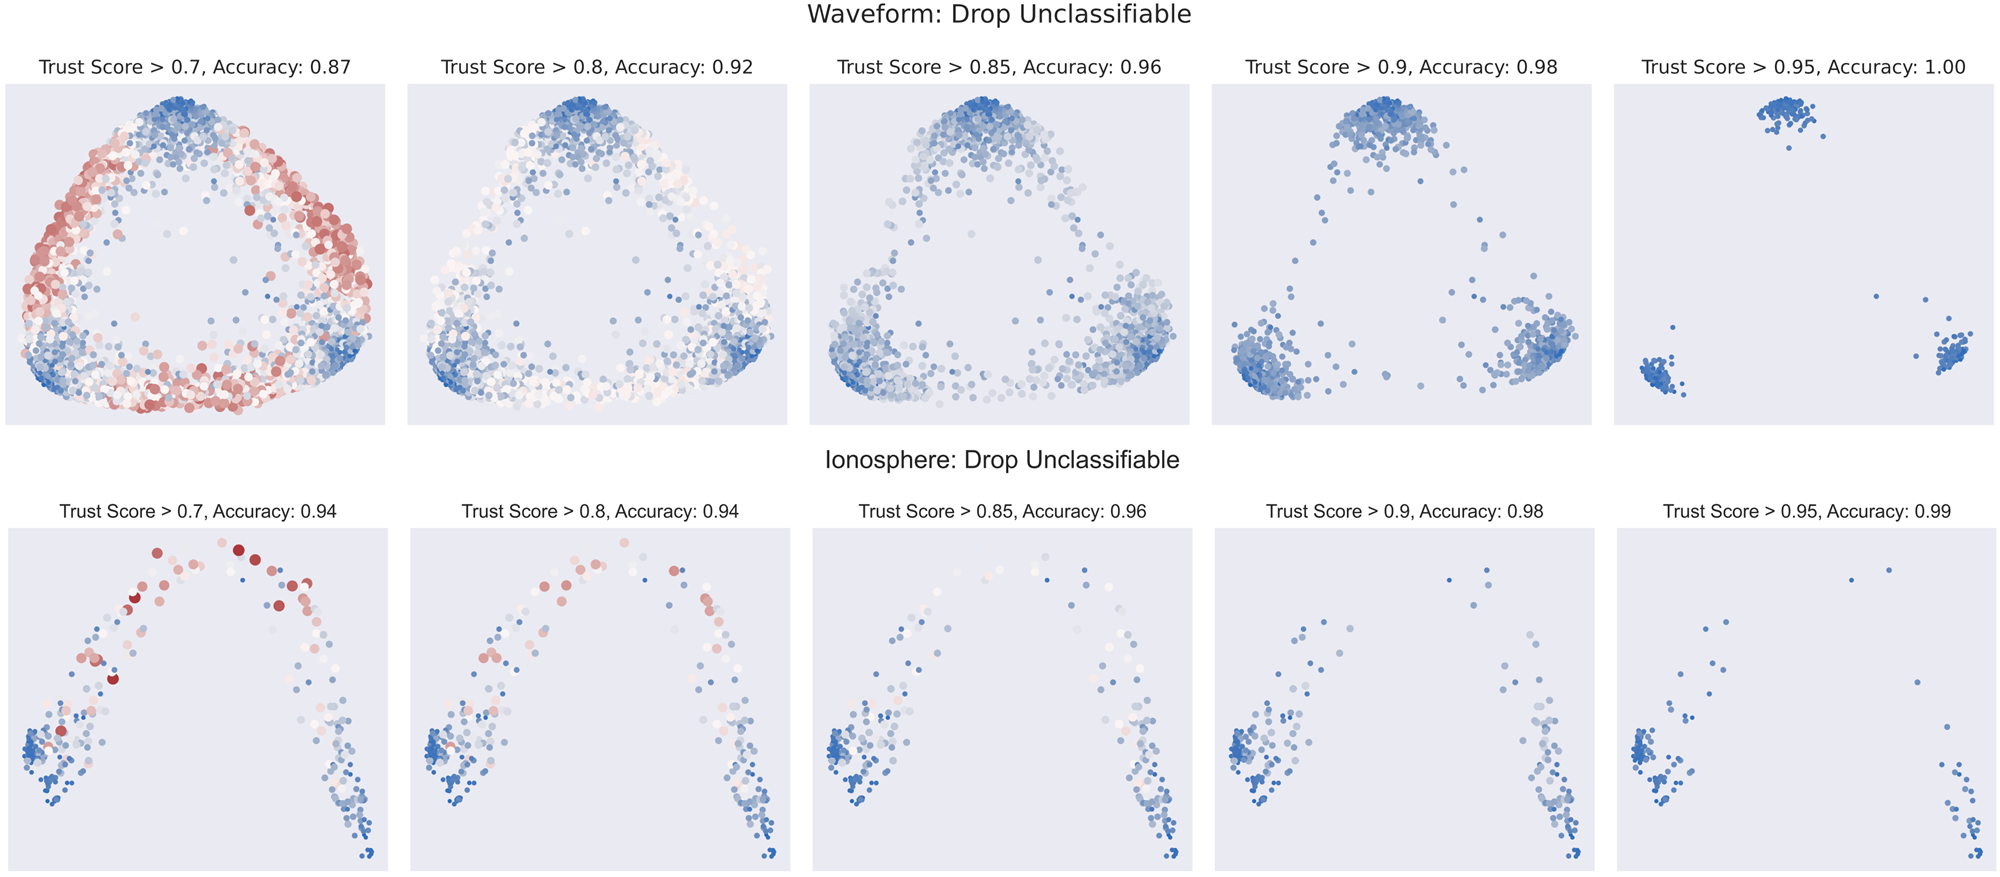

In [ ]:
rf.force_symmetric = False
rf.non_zero_diagonal = False
ice = rf.get_instance_classification_expectation()
print(ice)


In [ ]:
# Set the desired visual size range
min_size = .01
max_size = 10

# Scale the outlier scores to the range [min_size, max_size]
scaled_sizes = np.interp(outlier_scores, 
                         (outlier_scores.min(), outlier_scores.max()), 
                         (min_size, max_size))


hover_df['ice'] = np.where(ice > 0.99, ice, ice * 0.2)
hover_df['sizes'] = scaled_sizes

# Plot with scaled sizes
fig = px.scatter(
    data_frame=hover_df,
    x='UMAP 1',
    y='UMAP 2',
    color=y_train.astype(str),
    size='ice',
    size_max=max_size,
    labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'color': 'Survived'},
    title="Sizing by RF-ICE Scores",
    hover_data=hover_df[['age', 'sex_male', 'pclass', 'fare']],
    width=800,
    height=600,
)
fig.show()

In [ ]:
hover_df

## Now it is your turn!

### 1. Comparing Proximity Methods: `RF-GAP`, `original`, and `OOB`

Start by computing and visualizing proximities using three different methods:  
- `'rfgap'` (GAP-based proximities)  
- `'original'` (leaf co-occurrence on the training set)  
- `'oob'` (out-of-bag leaf co-occurrence)

**Things to try:**
- Use a 2D embedding (like UMAP or MDS) to visualize the proximity matrices.
- Compare how similar or different the cluster structures look.
- Notice that you **do not need to rescale** the `'original'` and `'oob'` proximities—they are already on a good scale.

*Play around by changing the `prox_method` and re-running the visualization.*

### 2. Playing with `n_estimators`: How Many Trees?

Try building random forests with different numbers of trees and observe how the proximities change.

**Suggestions:**
- Try **very small forests** (e.g., `n_estimators=5`)
- Try **very large forests** (e.g., `n_estimators=1000`)

**Questions to consider:**
- How stable are the proximity visualizations as the number of trees increases?
- Do the embeddings become clearer with more trees?

### 3a. Exploring `max_depth`: How Deep Can Trees Grow?

Vary the maximum depth of your trees and observe how it affects the structure of the proximity matrix.

**Try values like:**
- `max_depth=None` (grow fully until pure)
- `max_depth=5`, `max_depth=10`, etc.

**Think about:**
- Do shallow trees still capture meaningful proximity structures?
- Do deeper trees overfit and create noisy proximities?


### 3b. Exploring `min_samples_leaf`: How Small Can Leaves Be?

This controls the **minimum number of samples** required in a terminal leaf node. Try different values:

**Examples:**
- `min_samples_leaf=1` (very flexible)
- `min_samples_leaf=5`, `min_samples_leaf=10`, etc.

**Questions to explore:**
- How does increasing this parameter affect proximity smoothness?
- Do larger leaf sizes lead to more stable similarity structures?


### 3c. Exploring `max_features`: Feature Subsampling at Each Split

This parameter controls **how many features are considered when making a split**.

**Try values like:**
- `'sqrt'` (default for classification)
- `'log2'`, `None`, or even specific integers (e.g., `max_features=2`)

**Consider:**
- Does reducing `max_features` lead to more diverse trees (and hence better proximities)?
- How does it affect noise and overfitting in the proximity structure?